# CS475 MLNLP Homework 3: RNN & Transformer

## Submission Guide

This homework is based on a few number of sources, some of them are pytorch tutorial about Seq2Seq network and other AI/ML based courses in KAIST. In order to do this homework, you should be able to code using pytorch base function (such as `nn.Module`) and understand the equation of networks that we will implement here.

**How to submit**
- Fill out TODO blocks, DO NOT modify other parts of the skeleton code. Sample of TODO blocks:
```
##################
# TODO: Implement the forward function of LSTMCell
##################

# Your implementation code
pass

##################
# END OF YOUR CODE
##################
```
- Submit one file: hw3_{student_ID}.ipynb to KLMS e.g.hw3_20243150.ipynb
- Late submission policy: After the submission deadline, you will immediately lose 20% of the score, another 20% after 24 hours later, and so on. Submission after 72 hours (3 days) will not be counted. However, you can use late days for this assignment, for which you have to send an email to inform the TAs. See course syllabus website Late Policy section.

**Note**
- Make a copy of this .ipynb file. Do not directly edit this file.
- You cannot import any additional libraries other than provided in the skeleton code
- You cannot use some of the pytorch built-in classes such as `nn.Linear`, `nn.RNN`, `nn.LSTM`, `nn.LSTMCell`, etc. which correspond to things that we will implement here. Use your own implementation that you will be doing here instead.
- Some of the pytorch built-in classes are still allowed such as `nn.Parameter`, `nn.Embedding`, `nn.LayerNorm`, etc. Activation functions, optimizers, loss function, are also allowed.
- For all weights $W$, initialize the weights with a **random tensor** and **multiply it by 0.1 scale**
- For all bias $b$, must be **initialized to 0 tensor**
- Check whether your whole cells work well by restarting runtime code and running all before the submission.
- TA will look into the implemented functions, their validity and give corresponding score to each TODO problem.
- Ask questions through Slack so that you can share information with other students.
- TA in charge: Faiz Ghifari Haznitrama (haznitrama@kaist.ac.kr)

**In this programming assignment, you will**
- Understand the implementation of RNN and Transformer in pytorch, from low to high level


## Changelog

**v1.0.0**
- Release HW3

**v1.1.0**
- Fix potential bug when decoding text data by forcing encoding `utf-8`
- Move `set_random_seeds` forward to under Data Processing section
- Fix bug on text preprocessing by removing `contains_only_valid_characters` function when filtering the data, because it made the total filtered data under 1000
- Fix the output documentation of `RNNTranslator` `forward` function
- Change the implementation of `compute_accuracy` function by removing two lines of code that shift pred tokens and target seq
- - We remove this part since every student implementation in various parts related to this can be different
- Add assertion to check whether `predicted_tokens` and `target_seq` has the same shape or not in `compute_accuracy`
- Add more details about BOS_TOKEN and PAD_TOKEN that also must be ignored when implemmenting `evaluate_model`
- Add **important notes** regarding `batch_size` in Set Hyperparameters, Build Vocab, Load Dataset section

**v1.2.0**
- Fix infinite cell run on Tensorboard
- Remove any unused `dropout` documentation
- Remove the conflicting instruction above the code block at `TransformerTranslator` regarding the output of `predict()` function
- Change the expected shape of `tgt_mask` to `(b, n, n)` where `b` is batch size and `n` is target sequence length. This change include all docs regarding the `tgt_mask`
- Slightly change the `masked_softmax()` function based on the new shape of `tgt_mask`

**v1.2.1**
- Fix the documentation that states `nn.Linear` to `Linear`, which means the your own implementation of `Linear` 

## Preparation

In [1]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import re
import math
import requests
import unicodedata
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam
from tqdm import tqdm

### GPU Availability Check & Set Seed

Since we are going to train RNN and Transformer, make sure you work on this homework with CUDA capable machine.

In [ ]:
class CUDANotAvailableError(Exception):
    """Custom exception for when CUDA is required but not available."""
    def __init__(self, message="CUDA is required but not available on this system"):
        self.message = message
        super().__init__(self.message)

def check_cuda_availability():
    if not torch.cuda.is_available():
        raise CUDANotAvailableError()
    else:
        print("CUDA is available. Proceeding with GPU acceleration.")
        return torch.device("cuda:0")

def set_random_seeds(seed=42):
    """
    Set random seeds for reproducibility across different libraries
    
    Args:
        seed (int): The random seed to use. Default is 42.
    """
    # Set Python's random seed
    random.seed(seed)
    
    # Set NumPy's random seed
    np.random.seed(seed)
    
    # Set PyTorch's random seed
    torch.manual_seed(seed)
    
    # Set CUDA's random seed if available
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # for multi-GPU
      
      # These settings ensure deterministic behavior for CUDA
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
    else:
      raise CUDANotAvailableError()
    
    # Set environment variable for any other libraries
    os.environ['PYTHONHASHSEED'] = str(seed)

DEVICE = check_cuda_availability()

### Download Dataset

We are going to use the pytorch tutorial NMT English-France dataset. The function below should download the data and store it on the root directory.

In [3]:
def download_extract_read(url, zip_filename, txt_filename):
    
    if not os.path.isfile(zip_filename):
      # Download the zip file
      response = requests.get(url)
      if response.status_code != 200:
          raise Exception(f"Failed to download file. Status code: {response.status_code}")

      # Save the zip file
      with open(zip_filename, 'wb') as file:
          file.write(response.content)
      print(f"Zip file saved as {zip_filename}")

    if not os.path.isfile(txt_filename):
      # Extract the txt file from the zip
      with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
          zip_ref.extract(txt_filename)
      print(f"Extracted {txt_filename} from the zip file")

    # Read the contents of the txt file
    with open(txt_filename, 'r', encoding='utf-8') as file:
        text_content = file.read()
    print(f"Read the contents of {txt_filename}")

    return text_content

In [ ]:
raw_text = download_extract_read('https://download.pytorch.org/tutorial/data.zip', 'data.zip', 'data/eng-fra.txt')
print(raw_text[:200])

## Data Processing

Beforehand, we need to setup these parameters below. Since there are a lot of data and there are limited time and resource, we will filter the data to that has length of maximum 10. Other than that is the ID of pre-allocated tokens that we will use to build the vocabulary.

In [5]:
SEED = 42
MAX_LEN = 10
PAD_TOKEN = 0
BOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

set_random_seeds(SEED)

### Preprocess Text

For preprocessing, we mostly follow almost the same procedure as the pytorch Seq2Seq tutorial. We normalize the text and filter out some data.

In [6]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def contains_only_valid_characters(text):
    # Regular expression pattern to match allowed characters
    pattern = r'^[a-zA-Z0-9.,!? \t]*$'
    
    # Check if the text matches the pattern
    return bool(re.match(pattern, text))

def split_source_target(raw_text, max_len):
    sources, targets = [], []

    # Split raw text into lines
    lines = [line for line in raw_text.split('\n')]

    for line in lines:
        parts = line.split('\t')
        if len(parts) == 2:
          src = normalizeString(parts[0])
          tgt = normalizeString(parts[1])
          src_tokens = src.split(' ')
          tgt_tokens = tgt.split(' ')

          # Filter out data longer than max_len
          if (len(src_tokens) <= max_len) and (len(tgt_tokens) <= max_len) and src.startswith(eng_prefixes):
            sources.append(src_tokens)
            targets.append(tgt_tokens)
    
    return sources, targets

### Build Language Vocabulary

The `Lang` class is designed to handle language-specific tasks, building a vocabulary from a set of input data tokens. It manages the mapping between words (or tokens) and their corresponding integer indices, which is necessary for converting sequences of words into sequences of indices that can be used for training.

In [7]:
class Lang():
  def __init__(self, name, data_tokens):
    self.name = name
    self.index2word = {
      0: '<PAD>',
      1: '<BOS>',
      2: '<EOS>',
      3: '<UNK>'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.word2count = {v: 0 for _, v in self.index2word.items()}
    self.vocab_size = 4
    self.add_data(data_tokens)

  def add_data(self, data_tokens):
    for tokens in data_tokens:
      self.add_tokens(tokens)

  def add_tokens(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2count[token] = 1
        self.word2index[token] = self.vocab_size
        self.index2word[self.vocab_size] = token
        self.vocab_size += 1
      else:
        self.word2count[token] += 1

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['<UNK>'])
    else:
      return [self.__getitem__(token) for token in tokens]

### Build Data Loader

This code below to convert sequences of text into padded tensors inside a DataLoader that can be fed into a neural network. You should understand what it does in details to the dataset and DataLoader since it is one of the important things to do this homework correctly

In [8]:
def pad_tensor(line, padding_token):
  return line + [padding_token] * (MAX_LEN + 2 - len(line))

def build_tensor(text, lang, is_source):
  lines = [lang[line] for line in text] 
  if not is_source:
    lines = [[lang['<BOS>']] + line + [lang['<EOS>']] for line in lines]
  array = torch.tensor([pad_tensor(line, lang['<PAD>']) for line in lines])
  valid_len = (array != lang['<PAD>']).sum(1)
  return array, valid_len

def create_data_loader(indices, batch_size, src_array, src_valid_len, tgt_array, tgt_valid_len, shuffle=True):
    input_data = src_array[indices]
    input_valid_len = src_valid_len[indices]
    output_data = tgt_array[indices]
    output_valid_len = tgt_valid_len[indices]

    dataset = torch.utils.data.TensorDataset(input_data, input_valid_len, output_data, output_valid_len)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

def load_data_nmt(source, target, src_vocab, tgt_vocab, batch_size=2):
  rng = np.random.RandomState(SEED)

  # Generate a random permutation of indices
  indices = rng.permutation(len(source))

  # Calculate split sizes
  train_size = int(0.8 * len(source))
  val_size = int(0.1 * len(source))

  # Split indices based on the calculated sizes
  train_indices = indices[:train_size]  
  val_indices = indices[train_size:train_size + val_size]
  test_indices = indices[train_size + val_size:]

  src_array, src_valid_len = build_tensor(source, src_vocab, True)
  tgt_array, tgt_valid_len = build_tensor(target, tgt_vocab, False)

  train_iter = create_data_loader(train_indices, batch_size, src_array, src_valid_len, tgt_array, tgt_valid_len, shuffle=False)
  val_iter = create_data_loader(val_indices, batch_size, src_array, src_valid_len, tgt_array, tgt_valid_len, shuffle=False)
  test_iter = create_data_loader(test_indices, batch_size, src_array, src_valid_len, tgt_array, tgt_valid_len, shuffle=False)
  
  return train_iter, val_iter, test_iter

Let's test the function to build the DataLoader and check how many data we got after filtering.

In [ ]:
set_random_seeds(42)
src, tgt = split_source_target(raw_text, MAX_LEN)

print(len(src))

eng_vocab = Lang('eng', src)
fra_vocab = Lang('fra', tgt)

train_iter, val_iter, test_iter = load_data_nmt(src, tgt, eng_vocab, fra_vocab)

In [ ]:
for i, data in enumerate(train_iter):
    _, _, t_seq, t_len = data
    print(t_seq.shape)
    break

## Warm Up: Linear

To warm things up, let's implement a simple linear layer (fully connected layer) from scratch. You will write code that performs the forward pass for a linear transformation, applying the equation 
$$
\begin{align*}
y = xW + b
\end{align*}
$$
Where:
- $x$ is the input
- $W$ is the weight matrix
- $b$ is the bias

Rules:
- You are prohibited to use pytorch built-in linear layer `nn.Linear`
- For $W_x$, initialize the weights **randomly** and **multiply it by 0.1 scale**
- For $b_x$, must be **initialized to 0**

Instructions:
- Complete the `Linear` init() constructor and forward() forward pass function.

In [4]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        """
        Constructor for the Linear layer.
        
        Args:
            in_features (int): The number of input features (i.e., the size of the input dimension).
            out_features (int): The number of output features (i.e., the size of the output dimension).
            bias (bool): If True, includes a bias term. Defaults to True.
        
        Description:
            Initializes a linear layer that applies a linear transformation to the input. The weight 
            matrix is initialized with random values scaled by 0.1, and the bias (if included) is initialized 
            to zeros.
        """
        super(Linear, self).__init__()
        ####################################################################################
        # TODO: Implement the Linear constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, x):
        """
        Forward pass for the Linear layer.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, in_features), where 'batch_size' is the number of examples,
                        and 'in_features' is the number of input features (matches in_features from the constructor).
        
        Returns:
            Tensor: The output tensor of shape (batch_size, out_features), which is the result of applying
                    the linear transformation (weight matrix and optional bias) to the input.
        
        Description:
            Performs the forward pass according to the equation.
        """
        ####################################################################################
        # TODO: Implement the Linear forward pass
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return output


## RNN From Scratch

In this section, you will implement various types of Recurrent Neural Networks (RNNs) from scratch, including Vanilla RNN, LSTM, GRU, and a Seq2Seq network with both Encoder and Decoder. This will give you a deeper understanding of how these architectures work internally and how different RNN variants handle sequences.

Rules:
- Do not use PyTorch's built-in classes like `nn.RNN`, `nn.LSTM`, `nn.LSTMCell`, etc.
- Do not use `nn.Linear`; instead, use the `Linear` layer you previously implemented.
- You are allowed to use other PyTorch utilities like `nn.Embedding` where appropriate.
- Initialize all weights randomly and scale them by 0.1.
- Set all biases to 0.


### Vanilla RNN

The Vanilla RNN Cell processes data for one time step and return the hidden state. You'll implement the forward pass using the following equations:
$$
\begin{align*}
h_t &= \text{tanh}( x_tW_{hx} + h_{t-1}W_{hh} + b_h ) \\
\end{align*}
$$

Where:
- $x_t$ is input at time step $t$
- $h_{t-1}$ is hidden state at previous time step $t-1$
- $W_{hx}, W_{hh}$ are the weight matrices
- $b_h$ is the bias

Instructions:
- Complete the `VanillaRNNCell` init() constructor and forward() forward pass for one time step function.

In [5]:
class VanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Constructor for the VanillaRNNCell class.
        
        Args:
            input_size (int): The size (number of features) of the input data at each time step.
            hidden_size (int): The size (number of features) of the hidden state.
        
        Description:
            Initializes a vanilla RNN cell, which will compute the hidden state for one time step.
            The RNN cell uses two sets of weights: one for the input-to-hidden transformation (W_xh),
            and one for the hidden-to-hidden transformation (W_hh).
        """
        super(VanillaRNNCell, self).__init__()
        ####################################################################################
        # TODO: Implement the VanillaRNNCell constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, x_t, h_t_prev):
        """
        Forward pass for one time step.
        Args:
            x_t (Tensor): Input at time t (batch_size, input_size).
            h_t_prev (Tensor): Hidden state at time t-1 (batch_size, hidden_size).
        Returns:
            h_t (Tensor): Hidden state at time t (batch_size, hidden_size).
        """
        ####################################################################################
        # TODO: Implement the VanillaRNNCell forward pass
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return h_t

Now, by using the implemented `VanillaRNNCell`, implement the `VanillaRNN` which is the RNN that runs through the whole sequence.

Important things:
- If `h_0` is `None` then you should initialize the hidden state with 0 tensor.
- When running the forward pass, you should consider the valid lengths of the sequence, which you can found on the arg `valid_len`.
- Any kind of update to the hidden and cell state **beyond the valid lengths** are prohibited, to make sure that the last hidden and cell state are valid.
- Therefore, $h_t$ must not be updated if $t \geq \text{valid\_len}$

<div>
<img src="https://ethen8181.github.io/machine-learning/deep_learning/rnn/img/rnn_unrolled.png" width="600"/>
</div>
Image source: https://ethen8181.github.io/machine-learning/deep_learning/rnn/img/rnn_unrolled.png

Instructions:
- Utilize the `VanillaRNNCell` to implement the `VanillaRNN` init() constructor and forward() forward pass through the whole sequence.

In [7]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Constructor for the VanillaRNN class.
        
        Args:
            input_size (int): The size (number of features) of the input data at each time step.
            hidden_size (int): The size (number of features) of the hidden state.
        
        Description:
            Initializes the VanillaRNN model, which processes sequential input data across multiple time steps.
            This class uses the previously defined VanillaRNNCell to process one time step at a time.
            The RNN will maintain a hidden state of size `hidden_size` throughout the sequence.
        """
        super(VanillaRNN, self).__init__()
        ####################################################################################
        # TODO: Implement the VanillaRNN constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
    
    def forward(self, x, h_0=None, valid_len=None, **kwargs):
        """
        Forward pass for the entire sequence.
        Args:
            x (Tensor): Input sequence of shape (batch_size, seq_length, input_size).
            h_0 (Tensor, optional): Initial hidden state of shape (batch_size, hidden_size).
            valid_len (Tensor): Tensor of shape (batch_size,) containing the lengths of sequences before padding.
        Returns:
            h_seq (Tensor): Hidden states at each time step of shape (batch_size, seq_length, hidden_size).
            h_t (Tensor): The last hidden state for last time step of shape (batch_size, hidden_size)
        """
        batch_size, seq_length, _ = x.size()
        
        ####################################################################################
        # TODO: Implement the VanillaRNN forward pass. If h_0 is None, then the initial
        # hidden state should be initialized to 0 tensor. Also, implement the masking based
        # on the given valid_len if it is not None.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

        return h_seq, h_t

### LSTM

You'll implement a Long Short-Term Memory (LSTM) cell from scratch. LSTMs are powerful recurrent neural networks that can capture long-term dependencies in sequential data.
LSTM Equations
The LSTM cell is defined by the following equations:

$$
\begin{align*}
&\text{Input Gate} &&& I_t &= \sigma( x_tW_{xi} + h_{t-1}W_{hi} + b_i ) \\
&\text{Forget Gate} &&& F_t &= \sigma( x_tW_{xf} + h_{t-1}W_{hf} + b_f ) \\
&\text{Output Gate} &&& O_t &= \sigma( x_tW_{xo} + h_{t-1}W_{ho} + b_o ) \\
&\text{Cell State Candidate} &&& \tilde{C}_t &= \text{tanh}( x_tW_{xc} + h_{t-1}W_{hc} + b_c ) \\
&\text{Updated Cell State} &&& C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t \\
&\text{Hidden State} &&& h_t &= O_t \odot \text{tanh}(C_t) \\
\end{align*}
$$

Where:

- $\sigma$ is the sigmoid function
- $\odot$ denotes element-wise multiplication

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/450px-LSTM_Cell.svg.png" width="600"/>
</div>
Image source: https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/450px-LSTM_Cell.svg.png

Instructions:
- Complete the `LSTMCell` init() constructor and forward() forward pass for one time step function.

In [8]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Constructor for the LSTMCell class.
        
        Args:
            input_size (int): The number of features in the input data at each time step.
            hidden_size (int): The number of features in the hidden state.
        
        Description:
            Initializes the LSTM cell, which processes one time step of the input and updates both
            the hidden state (h_t) and cell state (c_t). LSTM cells have three gates: forget, input, 
            and output gates, which control the flow of information through the cell.
        """
        super(LSTMCell, self).__init__()
        ####################################################################################
        # TODO: Implement the LSTMCell constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, x_t, h_t_prev, c_t_prev):
        """
        Forward pass for one time step of LSTM.
        Args:
            x_t (Tensor): Input at time t (batch_size, input_size).
            h_t_prev (Tensor): Hidden state at time t-1 (batch_size, hidden_size).
            c_t_prev (Tensor): Cell state at time t-1 (batch_size, hidden_size).
        Returns:
            h_t (Tensor): Hidden state at time t (batch_size, hidden_size).
            c_t (Tensor): Cell state at time t (batch_size, hidden_size).
        """
        ####################################################################################
        # TODO: Implement the LSTMCell forward pass. Just implement it based the equation on
        # the equation and you should be fine.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

        return h_t, c_t

Now, by using the implemented `LSTMCell`, implement the `LSTM` which is the LSTM that runs through the whole sequence.

Important things:
- If `h_0` or `c_0` is `None` then you should initialize them with 0 tensor.
- When running the forward pass, you should consider the valid lengths of the sequence, which you can found on the arg `valid_len`.
- Any kind of update to the hidden and cell state **beyond the valid lengths** are prohibited, to make sure that the last hidden and cell state are valid.
- Therefore, $C_t$ and $h_t$ must not be updated if $t \geq \text{valid\_len}$

Instructions:
- Complete the `LSTM` init() constructor and forward() forward pass through the whole sequence.

In [1003]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Constructor for the LSTM class.
        
        Args:
            input_size (int): The number of features in the input data at each time step.
            hidden_size (int): The number of features in the hidden state.
        
        Description:
            Initializes the LSTM model, which processes sequential data across multiple time steps.
            This class uses the previously defined LSTMCell to compute the hidden and cell states at each 
            time step. It maintains a hidden state and a cell state of size `hidden_size` throughout the 
            sequence processing.
        """
        super(LSTM, self).__init__()
        ####################################################################################
        # TODO: Implement the LSTM constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
    def forward(self, x, h_0=None, c_0=None, valid_len=None):
        """
        Forward pass for the entire sequence.
        Args:
            x (Tensor): Input sequence of shape (batch_size, seq_length, input_size).
            h_0 (Tensor, optional): Initial hidden state of shape (batch_size, hidden_size).
            c_0 (Tensor, optional): Initial cell state of shape (batch_size, hidden_size).
            valid_len (Tensor, optional): Tensor containing the lengths of sequences before padding of shape (batch_size,).
        Returns:
            h_seq (Tensor): Hidden states at each time step with shape (batch_size, seq_length, hidden_size).
            (h_t, c_t) (Tuple): Final hidden and cell states with both shape (batch_size, 1, hidden_size).
        """
        batch_size, seq_length, _ = x.size()
        
        ####################################################################################
        # TODO: Implement the LSTM forward pass. Remember to initialize hidden and cell
        # state is not prodided and apply the mask to prevent prohibited updates.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return h_seq, (h_t, c_t)


### GRU

You'll implement a Gated Recurrent Unit (GRU) cell from scratch. GRU is a variation of LSTM with fewer parameters and comparable performance, making it an efficient choice for many sequence modeling tasks. The GRU cell is defined by the following equations:

$$
\begin{align*}
&\text{Reset Gate} &&& R_t &= \sigma( x_tW_{xr} + h_{t-1}W_{hr} + b_r ) \\
&\text{Update Gate} &&& Z_t &= \sigma( x_tW_{xz} + h_{t-1}W_{hz} + b_z ) \\
&\text{Hidden State Candidate} &&& \tilde{h}_t &= \text{tanh}( x_tW_{xh} + (R_t \odot h_{t-1})W_{hh} + b_h ) \\
&\text{Hidden States} &&& h_t &= (1 - Z_t) \odot h_{t-1} + Z_t \odot \tilde{h}_t \\
\end{align*}
$$

where:

- $\sigma$ is the sigmoid function
- $\odot$ denotes element-wise multiplication

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/1920px-Gated_Recurrent_Unit%2C_base_type.svg.png" width="600"/>
</div>
Image source: https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/1920px-Gated_Recurrent_Unit%2C_base_type.svg.png

Instructions:
- Complete the `GRUCell` init() constructor and forward() forward pass for one time step function.


In [9]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Constructor for the GRUCell class.
        
        Args:
            input_size (int): The number of features in the input data at each time step.
            hidden_size (int): The number of features in the hidden state.
        
        Description:
            Initializes a Gated Recurrent Unit (GRU) cell, which processes one time step of input and updates 
            the hidden state. A GRU cell uses two gates: an update gate and a reset gate, which control the 
            flow of information, and a candidate hidden state that proposes a new hidden state value.
        """
        super(GRUCell, self).__init__()
        ####################################################################################
        # TODO: Implement the GRUCell constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, x_t, h_t_prev):
        """
        Forward pass for one time step of GRU.
        Args:
            x_t (Tensor): Input at time t (batch_size, input_size).
            h_t_prev (Tensor): Hidden state at time t-1 (batch_size, hidden_size).
        Returns:
            h_t (Tensor): Hidden state at time t (batch_size, hidden_size).
        """
        ####################################################################################
        # TODO: Implement the GRUCell forward pass. Follow the provided equation.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

        return h_t


Now, by using the implemented `GRUCell`, implement the `GRU` which is the GRU that runs through the whole sequence.

Important things:
- If `h_0` is `None` then you should initialize the hidden state with 0 tensor.
- When running the forward pass, you should consider the valid lengths of the sequence, which you can found on the arg `valid_len`.
- Any kind of update to the hidden and cell state **beyond the valid lengths** are prohibited, to make sure that the last hidden and cell state are valid.
- Therefore, $h_t$ must not be updated if $t \geq \text{valid\_len}$

Instructions:
- Complete the `GRU` init() constructor and forward() forward pass through the whole sequence.

In [11]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        ####################################################################################
        # TODO: Implement the GRU constructor
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
    def forward(self, x, h_0=None, valid_len=None, **kwargs):
        """
        Forward pass for the entire sequence.
        Args:
            x (Tensor): Input sequence of shape (batch_size, seq_length, input_size).
            h_0 (Tensor, optional): Initial hidden state of shape (batch_size, hidden_size).
            valid_len (Tensor, optional): Tensor containing the lengths of sequences before padding of shape (batch_size,).
        Returns:
            h_seq (Tensor): Hidden states at each time step of shape (batch_size, seq_length, hidden_size).
            h_t: Final hidden state (batch_size, hidden_size).
        """
        batch_size, seq_length, _ = x.size()
        
        ####################################################################################
        # TODO: Implement the GRU forward pass. Do not forget to initialize hidden state if
        # not any and prevent unwanted state updates.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

        return h_seq, h_t

### Encoder

In this task, you will implement an RNNEncoder that processes sequences of word indices and returns the final hidden (and cell) states. Your implementation of this RNNEncoder must be able to use any RNN variant you've previously implemented, such as Vanilla RNN, LSTM, or GRU.

Key components of the encoder:
- **Embedding layer**: Transforms word indices into dense vectors.
- **RNN layer**: Applies your custom RNN implementation (without using PyTorch's built-in RNN classes).

The forward pass takes in the input sequences and sequence lengths, then outputs the final hidden state (and cell state if using LSTM). Follow the given code structure to integrate your RNN variants into this encoder.

Instructions:
- Complete the `RNNEncoder` init() constructor and forward() forward pass.

In [12]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, rnn_net):
        super(RNNEncoder, self).__init__()
        """
        Args:
            vocab_size (int): Number of unique words in the source vocabulary.
            embed_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the hidden state in the RNN.
            rnn_net: Any of your RNN variants that already implemented.
        """
        ####################################################################################
        # TODO: Implement the RNNEncoder constructor. You can use `nn.Embedding` for the
        # embedding layer.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, input_seq, valid_len):
        """
        Args:
            input_seq (Tensor): Tensor of shape (batch_size, sequence_length) containing word indices.
            valid_len (Tensor): Tensor of shape (batch_size,) containing the lengths of sequences before padding.

        Returns:
            final_hidden (Tensor): Tensor of shape (batch_size, hidden_dim) representing the final hidden states.
            final_cell (Tensor or None): Either
              1. Tensor of shape (batch_size, hidden_dim) representing the final cell states if the rnn_net is LSTM.
              2. None if the rnn_net is not LSTM
        """
        ####################################################################################
        # TODO: Implement the RNNEncoder forward pass. You must embed the input sequence to
        # before put it into the RNN layer. Remember, output of RNN layer can be different
        # depending on the type of RNN. Your code must be able to handle all of the
        # implemented RNN variants.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return final_hidden, final_cell

### Decoder

In this task, you will implement an RNNDecoder that generates sequences of word indices based on an initial hidden (and cell) state, using any of the RNN variants you have previously implemented (Vanilla RNN, LSTM, GRU). The decoder can operate in two modes:
- **Teacher Forcing**: When a target sequence is provided, the decoder uses the target tokens as inputs for each time step.
- **Inference**: When no target sequence is given, the decoder generates tokens one by one, feeding the predicted token from the previous step as the input for the next.

The decoder consists of:
- An **embedding layer** to convert word indices into dense vectors.
- Your **custom RNN layer** (without using PyTorch's built-in RNNs).
- An **output layer** to map hidden states to vocabulary scores.

Follow the structure provided to implement this functionality, ensuring you apply the RNN and sequence generation logic correctly.

Instructions:
- Complete the `RNNDecoder` init() constructor and forward() forward pass.

In [13]:
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, rnn_net):
        super(RNNDecoder, self).__init__()
        """
        Args:
            vocab_size (int): Number of unique words in the target vocabulary.
            embed_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the hidden state in the RNN.
        """
        ####################################################################################
        # TODO: Implement the RNNDecoder constructor. You can use `nn.Embedding` for the
        # embedding layer. Do not use `nn.Linear`, use your implemented Linear class instead
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, initial_hidden, initial_cell=None, target_seq=None):
        """
        Args:
            initial_hidden (Tensor): Tensor of shape (batch_size, hidden_dim) representing the initial hidden state.
            initial_cell (Tensor or None): Either 
              1. Tensor of shape (batch_size, hidden_dim) representing the initial cell state if rnn_net is LSTM.
              2. None if rnn_net is not LSTM
            target_seq (Tensor): Tensor of shape (batch_size, target_sequence_length) containing word indices.

        Returns:
            outputs (Tensor): Tensor of shape (batch_size, target_sequence_length, vocab_size) with raw scores.
            hidden_state (Tensor): Tensor containing the final hidden state.
        """
        batch_size = initial_hidden.size(0)

        if target_seq is not None:
            ####################################################################################
            # TODO: Implement the RNNDecoder forward pass when the target_seq is available. That
            # means you must implement the forward pass using teacher forcing, where you force
            # the input of every time step according to the target sequence provided, instead of
            # using the previously predicted token as input.
            ####################################################################################

            # Your implementation code
            pass

            ####################################################################################
            # END OF YOUR CODE
            ####################################################################################
       
            return outputs, hidden_state
        else:
            ####################################################################################
            # TODO: Implement the RNNDecoder forward pass when the target_seq is not available.
            # In this case, the model runs in inference mode. Therefore you should use the
            # previously predicted token as the input token to predict the next token. Also, do
            # not forget that the first input is always a BOS_TOKEN, which you must use at the
            # first time step.
            ####################################################################################

            # Your implementation code
            pass

            ####################################################################################
            # END OF YOUR CODE
            ####################################################################################
            
            return outputs, hidden_state

### RNNTranslator

Here, you will implement an RNNTranslator that combines the encoder-decoder architecture to perform sequence-to-sequence translation. The translator uses your custom RNNEncoder and RNNDecoder implementations (e.g., Vanilla RNN, LSTM, GRU) to translate a sequence from a source language to a target language.

Key components of the RNNTranslator:
- **Encoder**: Encodes the source sequence into a final hidden state (and cell state if using LSTM).
- **Decoder**: Generates the target sequence based on the encoder's output and the target sequence during training.

The model includes:
- A `forward` method to handle the translation during training with teacher forcing.
- A `predict` method to perform inference and generate translations step-by-step.

Your task is to implement the translation process by linking the encoder and decoder together, ensuring the hidden states are passed correctly between them.

Instructions:
- Complete the `RNNTranslator` init(), forward(), and predict() function.

In [15]:
class RNNTranslator(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, enc_net, dec_net):
    super(RNNTranslator, self).__init__()
    ####################################################################################
    # TODO: Implement the RNNTranslator constructor
    ####################################################################################

    # Your implementation code
    pass

    ####################################################################################
    # END OF YOUR CODE
    ####################################################################################

  def forward(self, source_seq, source_lengths, target_seq, target_lengths):
        """
        Args:
            source_seq (Tensor): Source sequences (batch_size, source_sequence_length).
            source_lengths (Tensor): Lengths of source sequences before padding (batch_size,).
            target_seq (Tensor): Target sequences (batch_size, target_sequence_length).
            target_lengths (Tensor): Lengths of target sequences before padding (batch_size,).

        Returns:
            logits (Tensor): Logits of shape (batch_size, tgt_seq_len, tgt_vocab_size), representing predicted token probabilities.
        """
        batch_size = source_seq.size(0)

        ####################################################################################
        # TODO: Implement the RNNTranslator forward pass by running the forward pass of the
        # Encoder continued by the Decoder.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return logits

  def predict(self, source_seq, source_lengths):
      """
      Generates translations for the given source sequences.

      Args:
          source_seq (Tensor): Source sequences (batch_size, source_sequence_length).
          source_lengths (Tensor): Lengths of source sequences before padding (batch_size,).

      Returns:
          predicted_tokens (Tensor): Generated token indices (batch_size, max_length).
      """
      batch_size = source_seq.size(0)

      ####################################################################################
      # TODO: Implement the RNNTranslator prediction function. Should be similar with
      # the forward pass but not the same. Keep notes that you should return predicted
      # tokens and not logits.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################

      return predicted_tokens

## Model Training and Evaluation

### Tensorboard

Before run the training and evaluation, run the Tensorboard to log your loss and other metrics from training and evaluation. Use this to track your experiments.

In [ ]:
!pip install tensorboard # install tensorboard first if not installed
%load_ext tensorboard
%tensorboard --logdir=runs # run the tensorboard. you can run it directly if you use Colab, but if you run it locally, then run this command on the terminal/command line

### Accuracy Metric

Below is the function to compute the accuracy given the tensor of predicted tokens and target data. The accuracy score for a batch is average of accuracy scores from all batch data.

You must make sure all the inputs are in the same device. One of the option is to move all of them to CPU first rather than compute it on GPU, before you put them into this function.

In [16]:
def compute_accuracy(predicted_tokens, target_seq, target_len):
    # Make sure pred tokens and target seq has the same shape
    assert predicted_tokens.shape == target_seq.shape

    # Create a mask for valid tokens (excluding padding)
    max_len = target_seq.size(1)
    batch_size = target_seq.size(0)
    
    # Create a mask tensor where 1 indicates valid tokens and 0 indicates padding
    mask = torch.arange(max_len).expand(batch_size, max_len).to(target_len.device) < (target_len - 1).unsqueeze(1)
    
    # Compare predicted tokens with true tokens
    correct_predictions = (predicted_tokens == target_seq) & mask
    
    # Calculate the number of correct predictions and sequence lengths for each sample
    correct_counts = correct_predictions.sum(dim=1).float()
    sequence_lengths = mask.sum(dim=1).float()
    
    # Calculate accuracy for each sequence
    batch_accuracy = correct_counts / sequence_lengths
    
    return batch_accuracy

### Training

Now you will implement a training loop for a Translator model using PyTorch. This training loop will be used not only for the RNNTranslator, but also re-used for the TransformerTranslator which you will be implemented after this section. The training loop will:
- Iterate over the training and validation datasets, train you model and check it through the validation dataset.
- Compute both training and validation loss while ignoring padding tokens, and perform backpropagation and optimization. Some notes:
  - Use `Adam` as the optimizer.
  - Depending on how you manipulate the output tensor matrices, you can either use `CrossEntropyLoss` of `NLLLoss` for the loss function.
  - The `BOS_token` and `PAD_token` must be ignored when calculating the loss. Therefore, you must only calculate the loss through the valid length - 1 (excluding), or until the `EOS_token` of the input sequence.
  - The final calculated loss for each data is the average loss from all token losses in the sequence. Sum it for all training data to obtain the total training loss for 1 epoch, which should be logged.
- Log training and validation loss and accuracy to TensorBoard for monitoring. Use arg `run_name` to track your run.

Instructions:
- Complete the `train_model()` function.

In [30]:
def train_model(model, train_iter, val_iter, lr, epochs, device, run_name="experiment-1"):
    """
    Trains a Translator model.

    Args:
        model (nn.Module): The Translator model to train.
        train_iter (DataLoader): Training data iterator.
        val_iter (DataLoader): Validation data iterator.
        lr (float): Learning rate.
        epochs (int): Number of epochs to train.
        device (device): Device used to train.
        run_name (str): Run name to log on Tensorboard.
    """
    model.to(device)

    ####################################################################################
    # TODO: Setup the optimizer and loss function based on the explanation above
    ####################################################################################

    # Your implementation code
    pass

    ####################################################################################
    # END OF YOUR CODE
    ####################################################################################

    # Set up TensorBoard writer
    writer = SummaryWriter(log_dir=f'runs/{run_name}')

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_batches = 0

        # Iterate over training batches
        for _, train_data in tqdm(enumerate(train_iter), desc=f"Epoch {epoch} Training"):
            ####################################################################################
            # TODO: Implement the model training for one batch. Here you must
            # 1. Do the forward pass through the model
            # 2. Update the gradients through backpropagation
            # 3. Compute the training loss, according to the explanation above
            ####################################################################################

            # Your implementation code
            pass

            ####################################################################################
            # END OF YOUR CODE
            ####################################################################################

        average_train_loss = total_train_loss / total_train_batches

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_batches = 0

        with torch.no_grad():
            for _, val_data in tqdm(enumerate(val_iter), desc=f"Epoch {epoch} Validation"):
                ####################################################################################
                # TODO: Implement the model validation for one batch. Here you must
                # 1. Do the forward pass through the model
                # 2. Compute the validation loss, according to the explanation above
                ####################################################################################

                # Your implementation code
                pass

                ####################################################################################
                # END OF YOUR CODE
                ####################################################################################

        average_val_loss = total_val_loss / total_val_batches

        # Log to TensorBoard
        writer.add_scalar('Loss/Train', average_train_loss, epoch)
        writer.add_scalar('Loss/Validation', average_val_loss, epoch)

        # Print epoch summary
        print(f"""Epoch {epoch}/{epochs}
Train Loss: {average_train_loss:.4f}
Validation Loss: {average_val_loss:.4f}\n""")

    # Close the TensorBoard writer
    writer.close()

    return model

### Evaluation

Below you should implement the evaluation loop. Same with calculating loss, the `BOS_token` and `PAD_token` must also be ignored when calculating the accuracy. Given the model and a dataloader, use the model to predict the data and compute the accuracy using the provided `compute_accuracy` function.

Instructions:
- Complete the `evaluate_model()` function.

In [31]:
def evaluate_model(model, eval_iter, device):
    """
    Runs prediction and evaluates the a Translator model on the given data iterator.
    
    Args:
        model (nn.Module): The trained a Translator model.
        eval_iter (DataLoader): Data iterator for evaluation data.
        device (torch.device): Device to run the model on.
        
    Returns:
        overall_accuracy (float): Overall accuracy of the model on the evaluation data.
    """
    model.to(device)
    model.eval()

    all_accuracies = []

    with torch.no_grad():
        for _, eval_data in enumerate(eval_iter):
            ####################################################################################
            # TODO: Implement the model evaluation for one batch. Here you must
            # 1. Do the model prediction
            # 2. Use the provided compute_accuracy() function to get batch accuracy
            ####################################################################################

            # Your implementation code
            pass

            ####################################################################################
            # END OF YOUR CODE
            ####################################################################################
      
    overall_accuracy = torch.cat(all_accuracies).mean()

    return overall_accuracy

## Set Hyperparameters, Build Vocab, Load Dataset

Now we are ready to train our model. Let's setup the hyperparameters and re-build and re-load the vocab and the dataloader.

**IMPORTANT NOTES**

Since one of the parameters of `load_data_nmt` is `batch_size`, you should make sure to re-load the dataset if you change the batch size, especially when experimenting with hyperparameters.

In [1031]:
batch_size = 64
lr = 1e-3
epochs = 10
embed_dim = 64
hidden_dim = 512

src, tgt = split_source_target(raw_text, MAX_LEN)

eng_vocab = Lang('eng', src)
fra_vocab = Lang('fra', tgt)

train_iter, val_iter, test_iter = load_data_nmt(src, tgt, eng_vocab, fra_vocab, batch_size=batch_size)

## RNNTranslator Training & Evaluation

We will train your implementation of `RNNTranslator` with `VanillaRNN` as both Encoder and Decoder. If your all implementation above was right, then there should be no problem to run the code below. You also should inspect the training loss and the validation loss, whether there are something not right with your model.

In [ ]:
enc_net = VanillaRNN(embed_dim, hidden_dim)
dec_net = VanillaRNN(embed_dim, hidden_dim)
rnn_net = RNNTranslator(eng_vocab.vocab_size, fra_vocab.vocab_size, embed_dim, hidden_dim, enc_net, dec_net)

In [ ]:
trained_rnn_net = train_model(rnn_net, train_iter, val_iter, lr, epochs, DEVICE, run_name="VanillaRNN-VanillaRNN-baseline")

In [ ]:
acc = evaluate_model(trained_rnn_net, train_iter, DEVICE)
print(acc)

### Exploring RNNTranslator Variants

In the code block below, you must also run the training for both LSTM and GRU (where Encoder and Decoder has the same RNN variants). It is optional for you to explore if the Encoder and Decoder has different variants, but it is really helpful especially if you suspect something wrong with your code.

Instructions:
- (Mandatory) Run the training & evaluation for both LSTM and GRU where Encoder and Decoder has the same RNN variants. You should run the evaluation on the `train_iter` and `val_iter`, but **NOT** on `test_iter`
- (Optional) Explore RNNTranslator when it has different RNN variant between Encoder and Decoder.

In [19]:
# Your code below
pass
# You can use more than 1 code block to experiment on this

## Transformer From Scratch

The Transformer architecture, introduced in the "Attention Is All You Need" paper, revolutionized natural language processing by eliminating the need for recurrent neural networks while achieving superior performance.

In this section, you'll build each component of the Transformer, through the multi-head attention mechanism, the feed-forward networks, and finally the encoder and decoder. 

Key aspects you'll focus on:
- Multi-head attention mechanism
- Feed-forward neural networks + LayerNorm + Residual Connections
- Self-attention and cross-attention
- The overall encoder-decoder architecture

### Positional Encoding

Positional Encoding is crucial in Transformer architectures because the model itself contains no inherent understanding of word order. To inject information about the relative or absolute position of tokens in a sequence, we add positional encodings to the input embeddings.

The positional encoding for a position `pos `and dimension `i` is calculated using the following equations:

For even indices (i = 0, 2, 4, ...):
```
PE(pos, i) = sin(pos / 10000^(i/d_model))
```

For odd indices (i = 1, 3, 5, ...):
```
PE(pos, i) = cos(pos / 10000^(i/d_model))
```

where:
- `pos` is the position of the token in the sequence
- `i` is the dimension in the embedding vector
- `d_model` is the dimensionality of the model's embeddings

In [1063]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Initialize the PositionalEncoding layer.
        
        Args:
            d_model (int): The dimensionality of the model embeddings
            dropout (float): Dropout probability (default: 0.1)
            max_len (int): Maximum sequence length to pre-compute (default: 5000)
        
        Creates:
            pe (Tensor): Positional encoding buffer of shape (1, max_len, d_model)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model/2)
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Add positional encoding to input embeddings.
        
        Args:
            x (Tensor): Input embeddings of shape (batch_size, seq_len, d_model)
        
        Returns:
            Tensor: Embeddings with positional encoding added and dropout applied,
                   shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### Masked Softmax

Masked Softmax is a crucial component in Transformer architectures, used to prevent certain attention connections. The regular softmax function is defined as:
```
softmax(x_i) = exp(x_i) / Σ_j exp(x_j)
```

Masked softmax modifies this by setting certain values to negative infinity before applying softmax:
```
masked_softmax(x_i) = 0 if i is masked 
                      exp(x_i) / Σ_j exp(x_j) otherwise
```
    
**Types of Masks**

1. Source Mask (Encoder Self-Attention & Decoder Cross-Attention):
  - Shape: (B, 1, m), where B is batch size and m is key sequence length
  - Used to mask padding tokens in the source sequence
  - Prevents attention to padding tokens
2. Target Mask (Decoder Self-Attention):
  - Shape: (B, n, n), where n is query/target sequence length
  - Used to prevent attention to future tokens and to padding tokens
  - Creates causal/autoregressive attention pattern

In [1]:
def masked_softmax(vector, mask, dim=-1):
    """
    Performs masked softmax. Works for both source and target masks.

    Args:
        vector: Tensor of shape (B, num_heads, n, m) where B is batch size,
               num_heads is num_heads, n is num_queries, and m is num_keys
        mask: Boolean mask that can be either:
              - Source mask of shape (B, 1, m) for encoder-decoder attention
              - Target mask of shape (B, n, n) for self-attention in decoder
        dim: Dimension to apply softmax over, default is -1

    Returns:
        Tensor of shape (B, n, m) with masked softmax probabilities
    """
    # Adjusting mask shape and type if needed
    if mask.dim() == 3:  # Need to add num_heads dimension
        if mask.size(1) == mask.size(2):  # Target mask case: (B, n, n) -> (B, 1, n, n)
            mask = mask.unsqueeze(1)
        else:  # Source mask case: (B, 1, m) -> (B, 1, 1, m)
            mask = mask.unsqueeze(1)
    
    # Convert boolean mask to float mask where True is -inf and False is 0
    float_mask = mask.float().masked_fill(mask, float('-inf'))
    
    # Add the mask to the vector
    masked_vector = vector + float_mask
    
    return F.softmax(masked_vector, dim=dim)

### Scaled Dot Product Attention

Scaled Dot Product Attention computes attention weights using queries, keys, and values. The formula is:

$$
\begin{align*}
\alpha(\mathbf{q}, \mathbf{k}) = \text{softmax}(\mathbf{Q} \mathbf{K}^T / \sqrt{d_k})V
\end{align*}
$$
where:
- Q is the query matrix
- K is the key matrix
- V is the value matrix
- d_k is the dimension of the keys
- √d_k is the scaling factor

The scaling factor √d_k prevents the dot products from growing too large in magnitude, leading to extremely small gradients in the softmax function.

<div>
    <img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="600"/>
    </div>
Image source: http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png

Instructions:
- Complete the `ScaledDotProductAttention` forward() function. In this case, use the provided `masked_softmax` instead of built-in softmax. Implement the function without using any loop

In [20]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self):
      super(ScaledDotProductAttention, self).__init__()

  def forward(self, query, key, value, mask=None):
    """
    inputs:
      query: tensor of size (B, num_heads, n, d)
      key: tensor of size (B, num_heads, m, d)
      value: tensor of size (B, num_heads, m, dim_v)
      mask: Boolean mask that can be either:
          - Source mask of shape (B, 1, m) for encoder-decoder attention
          - Target mask of shape (1, n, n) for self-attention in decoder

      B is the batch_size, num_heads is the number of attn head, n is the number of queries, m is the number of keys,
      d is the feature dimension of the query, and dim_v is the feature dimension of the value.

    Outputs:
      attention: tensor of size (B, num_heads, n, dim_v), weighted sum of values
    """
    ####################################################################################
    # TODO: Implement the ScaledDotProductAttention forward pass according to equation.
    # Use `masked_softmax()` instead of pytorch softmax. Do not use any loop.
    ####################################################################################

    # Your implementation code
    pass

    ####################################################################################
    # END OF YOUR CODE
    ####################################################################################

    return attention

### Multi-Head Attention

Multi-Head Attention allows the model to jointly attend to information from different representation subspaces. The mathematical formulation is:

$$
\begin{align*}
&\text{MultiHead(Q, K, V) = Concat}(\text{head}_1, ..., \text{head}_h)\text{W}^O \\
&\text{where head}_i = \text{Attention}(\text{QW}^\text{Q}_i, \text{KW}^\text{K}_i, \text{VW}^\text{V}_i)
\end{align*}
$$

The projections are parameter matrices:
- $W^Q_i ∈ ℝ^(d_{model} × d_k)$
- $W^K_i ∈ ℝ^(d_{model} × d_k)$
- $W^V_i ∈ ℝ^(d_{model} × d_v)$
- $W^O ∈ ℝ^(d_v × d_{model})$

In our case, since we pad both source and target sequence, therefore: $d_k = d_v = d_{model}$

<div>
    <img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" width="400"/>
    </div>
Image source: https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png

Instructions:
- Complete the `MultiHeadAttention` init() and forward() function. Use the `ScaledDotProductAttention` you have implemented. To expand the attention head into `num_heads`, you are **prohibited** to use any loop.


In [21]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
      """
      Initialize the Multi-Head Attention module.
        
        Args:
            d_model (int): The dimension of the model (input and output)
            num_heads (int): The number of attention heads
        
        Attributes:
            d_k (int): The dimension of each head (d_model / num_heads)
            linear_q (Linear): Linear projection for queries
            linear_k (Linear): Linear projection for keys
            linear_v (Linear): Linear projection for values
            linear_out (Linear): Final linear projection
            dot_product (ScaledDotProductAttention): Attention mechanism
        """
      super(MultiHeadAttention, self).__init__()
      assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
      ####################################################################################
      # TODO: Implement the MultiHeadAttention constructor. Think of all the attributes
      # that you need in order to run the forward pass.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################

  def forward(self, query, key, value, mask=None):
      """
        Compute multi-head attention.
        
        Args:
            query: Tensor of shape (batch_size, seq_len_q, d_model)
            key: Tensor of shape (batch_size, seq_len_k, d_model)
            value: Tensor of shape (batch_size, seq_len_v, d_model)
            mask: Optional boolean mask
        
        Returns:
            output: Tensor of shape (batch_size, seq_len_q, d_model)
        """
      batch_size = query.size(0)

      ####################################################################################
      # TODO: Implement the MultiHeadAttention forward pass. Implement it based on the eq.
      # and image. Do not use any loop.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################

      return output

### Positionwise FFNN

Positionwise FFNN is the forward pass consists of two linear transformations with a ReLU activation in between.

The mathematical equation for this layer can be described as:

$$
\begin{align*}
&\text{FFNN(}x\text{) = Linear}_2\text{(ReLU(Linear}_1\text{(} x \text{)))}
\end{align*}
$$

where:
- $\text{Linear}_1\text{(}x\text{) = } W_1x + b_1$ projects from `d_model` to `d_ff`.
- $\text{Linear}_2\text{(}x\text{) = } W_2x + b_2$ projects back from `d_ff` to `d_model`.
- ReLU applies a non-linear activation function.

Instructions:
- Complete the `PositionwiseFeedForward` init() and forward() function.

In [22]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        """
        Initializes the Positionwise FeedForward layer.

        Args:
            d_model (int): The input dimension (same as model's hidden size).
            d_ff (int): The dimension of the intermediate feedforward layer (usually larger than d_model).

        Returns:
            None: Initializes the layers for feedforward pass.
        """
        super(PositionwiseFeedForward, self).__init__()
        ####################################################################################
        # TODO: Implement the PositionwiseFeedForward constructor.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################

    def forward(self, x):
        """
        Forward pass of the Positionwise FeedForward layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, d_model).

        Returns:
            Tensor: Output tensor of shape (batch_size, sequence_length, d_model), same as input dimension.
                    The output goes through two linear transformations with a ReLU activation.
        """
        ####################################################################################
        # TODO: Implement the PositionwiseFeedForward forward pass. Follow the equation.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return x

### Transformer Encoder

The `TransformerEncoderLayer` is a building block of the Transformer model. Each layer consists of two key sub-layers:

- Multi-head self-attention
- Positionwise feedforward (FFNN)

Each sub-layer is followed by Layer Normalization and a Residual Connection. Residual connections help with gradient flow during training, and layer normalization helps stabilize learning.

The equations for `TransformerEncoderLayer` are:
$$
\begin{align*}
&\text{Self-Attention(}x\text{) = MultiHead(Q}_x\text{, K}_x\text{, V}_x) \\
&\text{Output: }x_1 = \text{LayerNorm}(x + \text{Self-Attention}(x)) \\
&\text{Positionwise FFNN: }x_2 = \text{LayerNorm}(x_1 + \text{FFNN}(x_1))
\end{align*}
$$

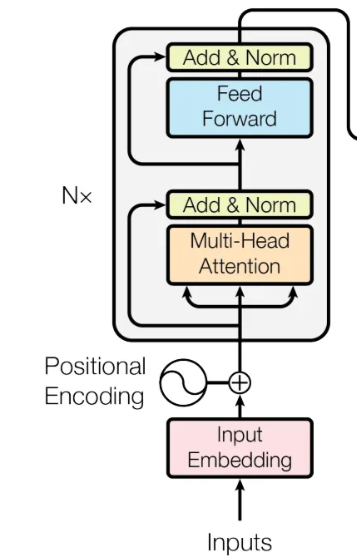

The `TransformerEncoder` is a stack of `N` `TransformerEncoderLayer` layers. The encoder uses embeddings to represent words and adds positional information since Transformers lack an inherent sense of word order.

The input goes through the following steps:
- Embedding: Each token is mapped to a dense vector representation.
- Positional Encoding: Positional information is added to the embeddings to account for sequence order.
- Stack of Encoder Layers: The input is passed through N encoder layers, each consisting of self-attention and feed-forward sub-layers.

Instructions:
- Complete both the `TransformerEncoderLayer` and `TransformerEncoder` init() and forward() function.
- You are allowed to use `nn.LayerNorm` for layer normalization, also allowed to use loop when implementing `N` stacks of `TransformerEncoderLayer`

In [24]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        """
        Initializes a single Transformer Encoder layer.

        Args:
            d_model (int): The input and output dimension size.
            num_heads (int): The number of attention heads in multi-head attention.
            d_ff (int): The dimension of the feed-forward network's hidden layer.

        Returns:
            None: Sets up self-attention, feed-forward, and normalization layers.
        """
        super(TransformerEncoderLayer, self).__init__()
        ####################################################################################
        # TODO: Implement the TransformerEncoderLayer constructor. Think of all building
        # blocks you need here. You are able to use `nn.LayerNorm` here. Use your
        # implemented `MultiHeadAttention` and `PositionwiseFeedForward`.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
    
    def forward(self, x, src_mask=None):
        """
        Forward pass for a single encoder layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, d_model).
            src_mask (Tensor, optional): Mask to avoid attending to certain positions, shape (batch_size, 1, seq_len).

        Returns:
            Tensor: Output tensor of shape (batch_size, sequence_length, d_model) after self-attention and FFNN.
        """
        ####################################################################################
        # TODO: Implement the TransformerEncoderLayer forward pass. Refer to the equation
        # and the image to be clear on how to implement it.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, num_heads, d_ff):
        """
        Initializes the Transformer Encoder consisting of multiple encoder layers.

        Args:
            vocab_size (int): Size of the vocabulary.
            d_model (int): The dimension of the input/output embeddings.
            N (int): Number of encoder layers (stacked TransformerEncoderLayers).
            num_heads (int): Number of attention heads in each layer's multi-head attention.
            d_ff (int): The dimension of the feed-forward network's hidden layer.

        Returns:
            None: Initializes the embedding, positional encoding, and encoder layers.
        """
        super(TransformerEncoder, self).__init__()
        ####################################################################################
        # TODO: Implement the TransformerEncoder constructor. Think of all building
        # blocks you need here. You are able to use `nn.Embedding` and `nn.ModuleList` here,
        # and use the provided `PositionalEncoding` class.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
    
    def forward(self, src, src_mask=None):
        """
        Forward pass for the full Transformer Encoder.

        Args:
            src (Tensor): Input source sequence tensor of shape (batch_size, sequence_length).
            src_mask (Tensor, optional): Source mask tensor of shape (batch_size, 1, seq_len), defaults to None.

        Returns:
            Tensor: Output tensor of shape (batch_size, sequence_length, d_model), the encoded representation of the input.
        """
        ####################################################################################
        # TODO: Implement the TransformerEncoder forward pass. Refer to the image to be
        # clear. You allowed to use loop here.
        ####################################################################################

        # Your implementation code
        pass

        ####################################################################################
        # END OF YOUR CODE
        ####################################################################################
        
        return x

### Transformer Decoder

The `TransformerDecoderLayer` is a core component of the Transformer decoder. Each layer consists of three main sub-layers:
- Self-attention: The decoder attends to its own output sequence, ensuring that each position in the sequence can capture dependencies from earlier positions.
- Cross-attention (Encoder-Decoder Attention): The decoder attends to the encoder's output (referred to as the "memory"), allowing the decoder to incorporate information from the source sequence.
- Feedforward Network (FFN)

The equations for `TransformerDecoderLayer` are:
$$
\begin{align*}
&\text{Self-Attention(}x\text{) = MultiHead(Q}_x\text{, K}_x\text{, V}_x) \\
&\text{Output: }x_1 = \text{LayerNorm}(x + \text{Self-Attention}(x)) \\
&\text{Cross-Attention(}x\text{, src) = MultiHead(Q}_x\text{, K}_{\text{src}}\text{, V}_{\text{src}}) \\
&\text{Output: }x_2 = \text{LayerNorm}(x + \text{Cross-Attention}(x)) \\
&\text{Positionwise FFNN: }x_3 = \text{LayerNorm}(x_2 + \text{FFNN}(x_2)) \\
\end{align*}
$$

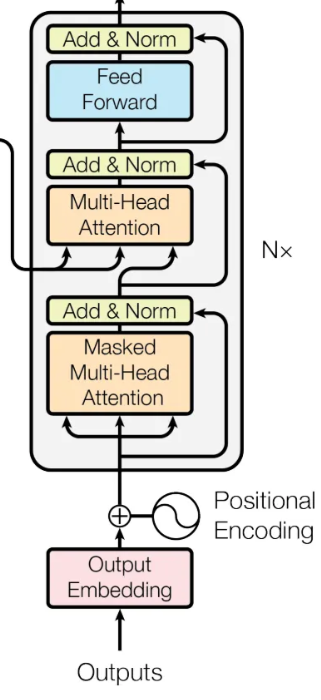

The `TransformerDecoder` is composed of a stack of `N` `TransformerDecoderLayers`. It is responsible for generating the target sequence by attending to both its own previous outputs (self-attention) and the encoder's output (cross-attention). It also includes an embedding layer to convert target token indices into dense vectors and positional encoding to add order information.

The input goes through similar steps to `TransformerEncoder`: Embedding -> Positional Encoding -> Stack of N `TransformerDecoderLayers`

Instructions:
- Complete both the `TransformerDecoderLayer` and `TransformerDecoder` init() and forward() function.
- You are allowed to use `nn.LayerNorm` for layer normalization, also allowed to use loop when implementing `N` stacks of `TransformerDecoderLayer`

In [28]:
class TransformerDecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff):
      """
      Initializes a single Transformer Decoder layer.

      Args:
          d_model (int): The dimension of the input/output embeddings.
          num_heads (int): Number of attention heads for self-attention and cross-attention.
          d_ff (int): Dimension of the feed-forward network's hidden layer.

      Returns:
          None: Sets up self-attention, cross-attention, feed-forward, and normalization layers.
      """
      super(TransformerDecoderLayer, self).__init__()
      ####################################################################################
      # TODO: Implement the TransformerDecoderLayer constructor. Think of all building
      # blocks you need here. You are able to use `nn.LayerNorm` and `nn.ModuleList` here,
      # and use your implemented `MultiHeadAttention` and `PositionwiseFeedForward` class.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################
  
  def forward(self, x, memory, src_mask=None, tgt_mask=None):
      """
      Forward pass for a single decoder layer.

      Args:
          x (Tensor): Input target sequence of shape (batch_size, target_seq_length, d_model).
          memory (Tensor): Encoder output (memory) of shape (batch_size, source_seq_length, d_model).
          src_mask (Tensor, optional): Mask for source sequence of shape (batch_size, 1, src_len), defaults to None.
          tgt_mask (Tensor, optional): Mask for the target sequence of shape (batch_size, target_seq_length, target_seq_length), defaults to None.

      Returns:
          Tensor: Output tensor of shape (batch_size, target_seq_length, d_model) after self-attention, cross-attention, and FFN.
      """
      ####################################################################################
      # TODO: Implement the TransformerDecoderLayer forward pass. Refer to the equation
      # and image, then fit them into your building blocks.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################
      
      return x
  
class TransformerDecoder(nn.Module):
      """
      Initializes the Transformer Decoder consisting of multiple decoder layers.

      Args:
          vocab_size (int): Size of the target vocabulary.
          d_model (int): Dimension of the input/output embeddings.
          N (int): Number of decoder layers (stacked TransformerDecoderLayers).
          num_heads (int): Number of attention heads in each layer's self-attention and cross-attention.
          d_ff (int): Dimension of the feed-forward network's hidden layer.

      Returns:
          None: Sets up the embedding, positional encoding, and N decoder layers.
      """
      def __init__(self, vocab_size, d_model, N, num_heads, d_ff):
          super(TransformerDecoder, self).__init__()
          ####################################################################################
          # TODO: Implement the TransformerDecoder constructor. Think of all building
          # blocks you need here. You are able to use `nn.Embedding` and `nn.ModuleList` here,
          # and use the provided `PositionalEncoding` class.
          ####################################################################################
      
      def forward(self, tgt, memory, src_mask=None, tgt_mask=None):
          """
          Forward pass for the full Transformer Decoder.

          Args:
              tgt (Tensor): Input target sequence tensor of shape (batch_size, target_seq_length).
              memory (Tensor): Encoder output (memory) tensor of shape (batch_size, source_seq_length, d_model).
              src_mask (Tensor, optional): Mask for the source sequence of shape (batch_size, 1, src_len), defaults to None.
              tgt_mask (Tensor, optional): Mask for the target sequence of shape (batch_size, target_seq_length, target_seq_length), defaults to None.

          Returns:
              Tensor: Output tensor of shape (batch_size, target_seq_length, d_model), representing the decoded output.
          """
          ####################################################################################
          # TODO: Implement the TransformerDecoder forward pass. Refer to the image to be
          # clear. You allowed to use loop here.
          ####################################################################################

          # Your implementation code
          pass

          ####################################################################################
          # END OF YOUR CODE
          ####################################################################################
          
          return x

### Transformer Translator

The `TransformerTranslator` is your final model which combine both `TransformerEncoder` and `TransformerDecoder` to build a Seq2Seq network. You will use this model to run the translation.

<div>
    <img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="400"/>
    </div>

The translation process works in two modes:
- Training Mode (forward): Given the source and target sequences, the model learns to translate by using teacher forcing (i.e., feeding the actual target sequence to the decoder).
- Inference Mode (predict): The model generates translations token by token, starting from a special "beginning-of-sequence" (BOS) token and stopping when it generates an "end-of-sequence" (EOS) token or reaches a maximum length.

**Mask**

As explained before in the `masked_softmax` function, there are masks that needs to be implemented here. There are two kind of masks:
1. Source Mask (Encoder Self-Attention & Decoder Cross-Attention) -> **src_mask**:
  - Shape: (B, 1, m), where B is batch size and m is key sequence length
  - Used to mask padding tokens in the source sequence
  - Prevents attention to padding tokens
2. Target Mask (Decoder Self-Attention) -> **tgt_mask**:
  - Shape: (B, n, n), where n is query/target sequence length
  - Used to prevent attention to future tokens, therefore a token cannot attend to all tokens after it
  - Also prevents attention to padding tokens
  - Creates causal/autoregressive attention pattern

Instructions:
- Complete the `TransformerTranslator` init(), forward(), and predict() function. The forward() is used for training therefore use Teacher Forcing, and the predict() is use for inference where tokens are generated autoregressively and become the input to predict next token.
- Implemented both `src_mask` and `tgt_mask` and put them as input to the Encoder and Decoder appropriately, in order for the attention to be calculated correctly. Both of these masks are used either in forward() or predict()
- Do not need to add Softmax at the end of the forward() or predict()

In [29]:
class TransformerTranslator(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, d_model=64, N=1, num_heads=4, d_ff=512):
      """
      Initializes the Transformer-based translation model.

      Args:
          src_vocab_size (int): The size of the source language vocabulary.
          tgt_vocab_size (int): The size of the target language vocabulary.
          d_model (int, optional): The dimension of the model's embeddings and hidden layers. Defaults to 512.
          N (int, optional): The number of encoder and decoder layers. Defaults to 6.
          num_heads (int, optional): The number of attention heads in multi-head attention. Defaults to 8.
          d_ff (int, optional): The dimension of the feed-forward network's hidden layer. Defaults to 2048.

      Returns:
          None: Initializes the encoder, decoder, and output layers.
      """
      super(TransformerTranslator, self).__init__()
      ####################################################################################
      # TODO: Implement the TransformerTranslator constructor. Think of all building
      # blocks you need here. You don't need to add softmax here, just until the linear
      # output layer, which you should use your own implementation of Linear
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################
  
  def forward(self, src, src_len, tgt, tgt_len):
      """
      Forward pass for the translation model during training (uses teacher forcing).

      Args:
          src (Tensor): Source sequence tensor of shape (batch_size, src_seq_len).
          src_len (Tensor): Source sequence lengths of shape (batch_size,).
          tgt (Tensor): Target sequence tensor of shape (batch_size, tgt_seq_len).
          tgt_len (Tensor): Target sequence lengths of shape (batch_size,).

      Returns:
          Tensor: Logits of shape (batch_size, tgt_seq_len, tgt_vocab_size), representing predicted token probabilities.
      """
      ####################################################################################
      # TODO: Implement the TransformerTranslator forward pass. This function will be use
      # at training, where target data are provided. Therefore, here we must use teacher
      # forcing same with to RNNTranslator. Also, we need to implement the two masks:
      # `src_mask` and `tgt_mask` which already explained above. Then, use the `src_mask`
      # and the `tgt_mask` accordingly to prevent unwanted attention. Do not need to add
      # softmax at the end of the function.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################
      
      return output
  
  def predict(self, src, src_len):
      """
      Greedy decoding to generate translations token-by-token during inference.

      Args:
          src (Tensor): Source sequence tensor of shape (batch_size, src_seq_len).
          src_len (Tensor): Source sequence lengths of shape (batch_size,).
      
      Returns:
          Tensor: Generated token IDs of shape (batch_size, max_len), representing the translated sequence.
      """
      batch_size = src.shape[0]
      device = src.device

      ####################################################################################
      # TODO: Implement the TransformerTranslator predict(). This function will be use
      # at inference, where there are no target data . Therefore, here we must do the
      # generation autoregressively. Means that we must generate the predicted token one
      # by one and use it as the input for the next token. Because of that, remember that
      # the first input is always the BOS_TOKEN.
      # Don't forget we still also need to implement the two masks, as in forward(). Also,
      # remember that the output is the generated token ID, and not the token logits.
      ####################################################################################

      # Your implementation code
      pass

      ####################################################################################
      # END OF YOUR CODE
      ####################################################################################
      
      return tgt

## TransformerTranslator Training & Evaluation

Below we will initialize, train, and evaluate your implemented `TransformerTranslator`. If you coded all the training and evaluation function properly, you should be able to re-use those function for the `TransformerTranslator`.

In [799]:
transformer_net = TransformerTranslator(eng_vocab.vocab_size, fra_vocab.vocab_size)

In [ ]:
trained_transformer_net = train_model(transformer_net, train_iter, val_iter, lr, epochs, DEVICE, run_name="Transformer-Baseline")

In [ ]:
acc = evaluate_model(trained_transformer_net, val_iter, DEVICE)
print(acc)

### Exploring TransformerTranslator Hyperparameters

There are a lot of things to tune on the `TransformerTranslator`. Therefore, do some little experiments to find the optimal hyperparameters for `TransformerTranslator`. The dataset that we used is considered small, with really short length. Maybe the excessive number of params could lead to degradation of performance.

Instructions:
- Explore different parameters of `TransformerTranslator`. Do training and evaluation on it, but do not run it on `test_iter`

In [1079]:
# YOUR CODE BELOW
pass

## Your Own RNN

As you can see from the RNN variants (also attention has some variants but not implemented here), for the same idea/mechanism you can have multiple algorithm on how to implement it. Now, use your creativity to define your own RNN algorithm. Then, use them in the RNNTranslator and see whether they are better than the 3 variants you have implemented.

Instructions:
- Implement the `MyRNNCell` and `MyRNN` class according to your idea of your RNN.
- Explain your idea and implementation
- Try train and evaluate your `MyRNN` using the `RNNTranslator`. Make sure it is compatible

In [ ]:
class MyRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
      pass

    def forward(self):
      pass

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
      pass

    def forward(self,):
      pass

TODO: Explain your idea and implementation of your RNN here.

In [25]:
## Your code to train MyRNN using RNNTranslator
pass

## Test Data Challenge

Your challenge is to experiment with different model architectures, hyperparameters, and training strategies to find the best-performing model on the validation data. Once you have identified your best model, you will then run it on the test data only once at the end of the process. Keep track of your experiments and results carefully, as the test run should only be performed once after you're found your best model. confident in your model's performance.

We will make a leaderboard for this and thus provide a bonus point for the top-5 performers.

Instructions:
- Feel free to experiment in order to find the best model.
- You can only use all building blocks that have been implemented in this code, no other code allowed from outside such as using pytorch built-in `nn.RNN` class
- The best model architecture and hyperparameters should be made clear, and thus save it on the variable `best_model`

In [26]:
### Your code to experiment finding the best model
pass

In [ ]:
best_acc = evaluate_model(best_model, test_iter, DEVICE)
print(best_acc)